In [1]:
%load_ext autoreload
%autoreload 2

import pprint
from typing import OrderedDict

import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision.datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

import models.resnet
import models.resnet_dropout
import models.unet_model
import utils.detection_metrics
import utils.metrics
import utils.model
import utils.visualisations
from utils.detection_utils import calculate_mAP
from pprint import PrettyPrinter



from utils.temperature_scaling import ModelWithTemperature

from datasets.voc_detection_dataset import PascalVOCDataset


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [57]:
# model = torchvision.models.detection.ssd300_vgg16(


#     pretrained=True, trainable_backbone_layers=0)



model = torch.load("checkpoints/ssd300_dropout.pt")
model.to(device)


SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [66]:
torch.save(model, "checkpoints/ssd300_dropout.pt")

In [58]:
from datasets.transforms import AddGaussianNoise

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

test_dataset = PascalVOCDataset("VOC",
                                split='test',
                                keep_difficult=True,
                                # transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor() ,AddGaussianNoise(std=0.3), torchvision.transforms.ToPILImage()]) 
                                )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                          collate_fn=test_dataset.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


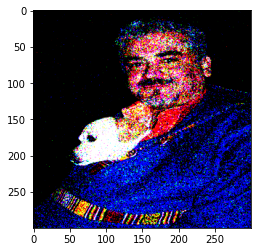

In [49]:
plt.imshow(test_dataset[0][0].permute((1,2,0)))

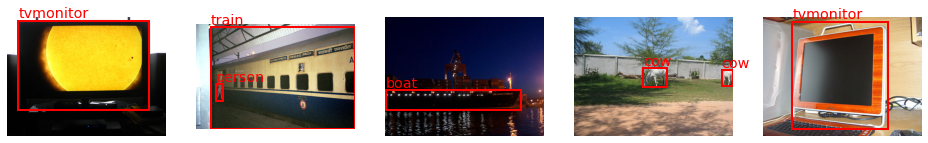

In [36]:
import matplotlib.patches as patches


num = 5
fig, axs = plt.subplots(1, num, figsize=(13,3), squeeze=False)
for i in range(num):
    axs[0][i].imshow(data_test[i][0].permute((1,2,0)))
    axs[0][i].axis("off")

    meta = data_test[i][1]
    for j in range(len(meta["labels"])):
        box = meta["boxes"][j]
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        axs[0][i].text(box[0], box[1] - 10 , VOC_CLASSES[int(meta["labels"][j])], c="red", fontsize="x-large")
        axs[0][i].add_patch(rect)

        
    # axs[1][i].imshow(decode_segmap(data_test[i][1]))
    # axs[1][i].axis("off")
plt.tight_layout()
plt.savefig("figures/voc-detection-examples.pdf")

In [68]:
# pp = PrettyPrinter()
import utils.mc_dropout

def validate(model, test_loader, mc_dropout_iters=0):
    model.to(device)
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py
    true_difficulties = list()

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            if mc_dropout_iters > 0:
                utils.mc_dropout.set_training_mode_for_dropout(model, True)
                locs_list = []
                scores_list = []
                for _ in range(mc_dropout_iters):
                     predicted_locs, predicted_scores = model(images)
                     locs_list.append(predicted_locs)
                     scores_list.append(predicted_scores)
                predicted_locs = torch.stack(locs_list).mean(dim=0)
                predicted_scores = torch.stack(scores_list).mean(dim=0)
                utils.mc_dropout.set_training_mode_for_dropout(model, False)

            else:
                # Forward prop.
                predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                        min_score=0.2, max_overlap=0.5,
                                                                                        top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader, mc_dropout_iters=10)
APs, mAP = calculate_mAP(
    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)
print('\nMean Average Precision (mAP) 50: %.3f' % mAP)

        # Calculate mAP
        # APs, mAP = calculate_mAP(
        #     det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)

        # # Print AP for each class
        # pp.pprint(APs)

        # print('\nMean Average Precision (mAP) 50: %.3f' % mAP)

        # APs, mAP = calculate_mAP(
        # det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.75)

        # # Print AP for each class
        # pp.pprint(APs)

        # print('\nMean Average Precision (mAP) 75: %.3f' % mAP)

Evaluating: 100%|██████████| 155/155 [06:34<00:00,  2.55s/it]



Mean Average Precision (mAP) 50: 0.722


In [77]:
det_boxes[0], det_labels[0], det_scores[0], true_boxes[0], true_labels[0]

(tensor([[0.0577, 0.4452, 0.5921, 0.8522],
         [0.0187, 0.0078, 0.9949, 0.9959]], device='cuda:0'),
 tensor([12, 15], device='cuda:0'),
 tensor([0.7084, 0.9990], device='cuda:0'),
 tensor([[0.1331, 0.4780, 0.5496, 0.7400],
         [0.0198, 0.0220, 0.9943, 0.9940]], device='cuda:0'),
 tensor([12, 15], device='cuda:0'))

In [32]:
from utils.detection_utils import find_jaccard_overlap

def classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels, iou_threshold=0.5):
    TP = []
    FP = []
    FN = []

    for img_idx, (bboxes, labels, scores, gt, gt_labels) in enumerate(zip(det_boxes, det_labels, det_scores, true_boxes, true_labels)):
        idx = torch.argsort(scores, descending=True)
        ious = find_jaccard_overlap(bboxes, gt)
        matched_gt_indexes = []
        matched_boxes_indexes = []
        for true_boxes_iou, box_idx in zip(ious[idx], idx):
            best_iou = 0
            best_iou_idx = None
            for true_boxes_idx, iou in enumerate(true_boxes_iou):
                if iou > best_iou and labels[box_idx] == gt_labels[true_boxes_idx] and true_boxes_idx not in matched_gt_indexes:
                    best_iou = iou
                    best_iou_idx = true_boxes_idx
            if best_iou > iou_threshold:
                TP.append((img_idx,box_idx.item()))
                matched_gt_indexes.append(best_iou_idx)
                matched_boxes_indexes.append(box_idx.item())
        for i, box in enumerate(gt):
            if i not in matched_gt_indexes:
                FN.append((img_idx,i))
        for i, box in enumerate(bboxes):
            if i not in matched_boxes_indexes:
                FP.append((img_idx,i))
    return TP, FP, FN

In [111]:
TP, FP, FN = classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels)

In [97]:
len(TP), len(FP), len(FN)

(10463, 5904, 4513)

In [9]:
import matplotlib.patches as patches

def plot_image(image, boxes, gt_boxes):
    """Plots predicted bounding boxes on the image"""
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1,2,0))
    im = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height
    img_shape = torch.tensor([300,300,300,300]).to(device)
    # Create a Rectangle potch
    for box in boxes:
        box = (box * img_shape).cpu()
        # cls = box[1]
        # confidence = box[2]
        # box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5,
            edgecolor="r",
            facecolor="none"
        )
        # plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="r")
        # Add the patch to the Axes
        ax.add_patch(rect)

    for box in gt_boxes:
        box = (box * img_shape).cpu()
        # cls = box[1]
        # box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5,
            edgecolor="g",
            facecolor="none"

        )
        # plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="g")

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 14


TypeError: iteration over a 0-d tensor

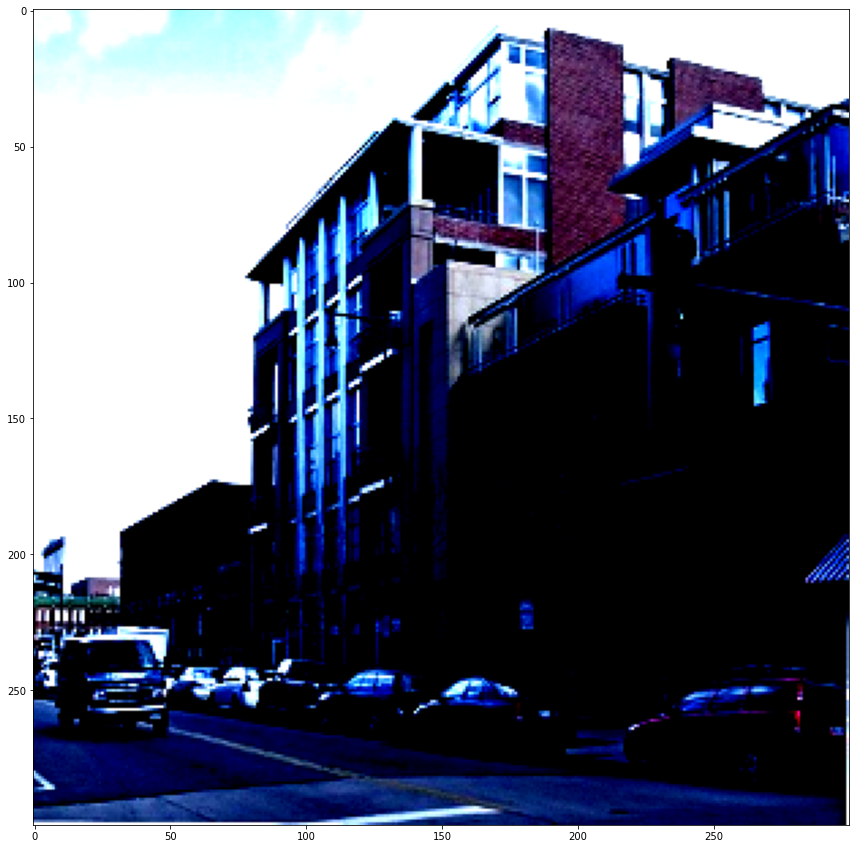

In [102]:
idx=3
TP, FP, FN = classify_boxes(det_boxes[idx:idx+1], det_labels[idx:idx+1], det_scores[idx:idx+1], true_boxes[idx:idx+1], true_labels[idx:idx+1])
print(len(TP)*2+ len(FP)+ len(FN), len(det_boxes[idx]) + len(true_boxes[idx]))
plot_image(test_dataset[idx][0], det_boxes[idx][TP[1]], FN)


In [98]:
from functools import reduce
len(TP)*2+ len(FP)+ len(FN), reduce(lambda count, l: count + len(l), det_boxes, 0) + reduce(lambda count, l: count + len(l), true_boxes, 0)

(31343, 31343)

In [115]:
correct = [1]*len(TP) + [0]*len(FP)
probs =[]
for img_idx,box_idx in TP+FP:
    probs.append(det_scores[img_idx][box_idx].item())
curves =[utils.metrics.compute_model_stats(correct, probs, "test")]

In [4]:
class detection_model_metrics:
    def __init__(self) -> None:
        self.map50 = []
        self.map75 = []
        self.auroc = []
        self.aupr = []
        self.TP = []
        self.FP = []
        self.FN = []
        self.confidences = []
        self.strengths = []

    def __repr__(self) -> str:
        return str(vars(self))

    def update(self, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, strength):
        self.strengths.append(strength)
        self.confidences.append(torch.cat(det_scores).mean())
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)
        self.map50.append(mAP)
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.75)
        self.map75.append(mAP)
        TP, FP, FN = classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels)
        self.TP.append(len(TP))
        self.FP.append(len(FP))
        self.FN.append(len(FN))

        correct = [1]*len(TP) + [0]*len(FP)
        probs = []
        for img_idx, box_idx in TP+FP:
            probs.append(det_scores[img_idx][box_idx].item())
        metrics = utils.metrics.compute_model_stats(correct, probs, "test")
        self.auroc.append(metrics["auroc"])
        self.aupr.append(metrics["aupr"])

In [ ]:


curves = {
    "Vanilla": detection_model_metrics(),
    "Dropout training": detection_model_metrics(),
    "MC Dropout":detection_model_metrics(),
}


for s in np.arange(0, 0.6, 0.05):
    print(s)

    test_dataset = PascalVOCDataset("VOC",
                                    split='test',
                                    keep_difficult=True,
                                    transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor() ,AddGaussianNoise(std=s), torchvision.transforms.ToPILImage()]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                            collate_fn=test_dataset.collate_fn)

    # det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader)
    # curves["Vanilla"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader)
    curves["Dropout training"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader, mc_dropout_iters=20)
    curves["MC Dropout"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    del det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties


    
    

: 

In [7]:
curves

{'Vanilla': {'map50': [0.7320129871368408, 0.6983374953269958, 0.6266477704048157, 0.518733561038971, 0.41305166482925415, 0.304100900888443, 0.21429617702960968, 0.14828424155712128, 0.10812973976135254, 0.0805836170911789, 0.0629759281873703, 0.039455048739910126], 'map75': [0.5199247598648071, 0.4906633496284485, 0.4235815107822418, 0.3356819748878479, 0.25191444158554077, 0.1875445395708084, 0.13854031264781952, 0.09417708963155746, 0.07030953466892242, 0.052343130111694336, 0.04009515047073364, 0.024416621774435043], 'auroc': [0.8794922461314836, 0.8710510662736966, 0.8539078005847389, 0.8327963373702241, 0.8056014674376039, 0.7778759367254175, 0.7547710973046363, 0.7357459625595821, 0.7095726395442432, 0.6823495101389838, 0.653625323737244, 0.6127446196266896], 'aupr': [0.9340788514752529, 0.9350050841054371, 0.9250608528448985, 0.9006208952343446, 0.8547787532701905, 0.7871246925179505, 0.6936410273206165, 0.5829801951408432, 0.44221769513359743, 0.3163843686655682, 0.2136335916

In [21]:
import pickle
with open("experiments/voc-detection-dropout-noise.pickle", "wb") as f:
    pickle.dump(curves,f)

In [5]:
import pickle
with open("experiments/voc-detection-all-noise.pickle", "rb") as f:
   curves = pickle.load(f)

In [22]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0].item() if isinstance(val[0], torch.Tensor) else val[0]
    df=df.append(row,ignore_index=True)
df=df.drop(["strengths"], axis=1)
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &             label &  map50 &  map75 &  auroc &  aupr &     TP &    FP &    FN &  confidences \\
\midrule
0 &           Vanilla &  0.732 &  0.520 &  0.879 & 0.934 &  10463 &  5904 &  4513 &        0.669 \\
1 &  Dropout training &  0.726 &  0.520 &  0.876 & 0.928 &  10467 &  6300 &  4509 &        0.649 \\
2 &        MC Dropout &  0.727 &  0.521 &  0.875 & 0.930 &  10412 &  5981 &  4564 &        0.652 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(fl

In [20]:
curves

{'Vanilla': {'map50': [0.7320129871368408, 0.6983374953269958, 0.6266477704048157, 0.518733561038971, 0.41305166482925415, 0.304100900888443, 0.21429617702960968, 0.14828424155712128, 0.10812973976135254, 0.0805836170911789, 0.0629759281873703, 0.039455048739910126], 'map75': [0.5199247598648071, 0.4906633496284485, 0.4235815107822418, 0.3356819748878479, 0.25191444158554077, 0.1875445395708084, 0.13854031264781952, 0.09417708963155746, 0.07030953466892242, 0.052343130111694336, 0.04009515047073364, 0.024416621774435043], 'auroc': [0.8794922461314836, 0.8710510662736966, 0.8539078005847389, 0.8327963373702241, 0.8056014674376039, 0.7778759367254175, 0.7547710973046363, 0.7357459625595821, 0.7095726395442432, 0.6823495101389838, 0.653625323737244, 0.6127446196266896], 'aupr': [0.9340788514752529, 0.9350050841054371, 0.9250608528448985, 0.9006208952343446, 0.8547787532701905, 0.7871246925179505, 0.6936410273206165, 0.5829801951408432, 0.44221769513359743, 0.3163843686655682, 0.2136335916

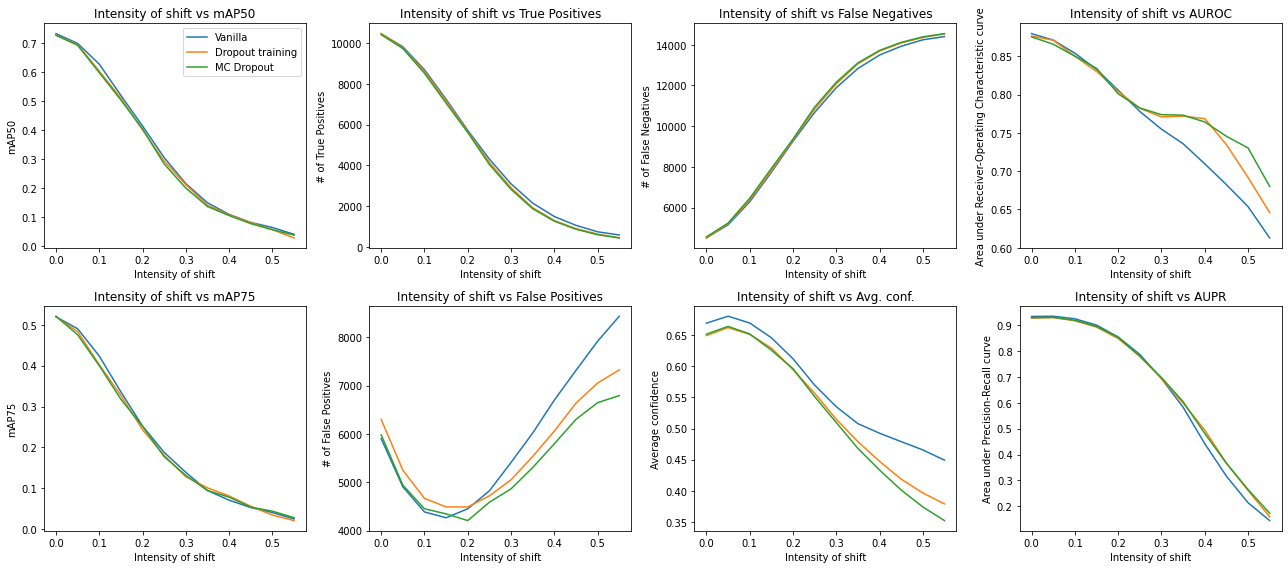

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.map50, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs mAP50")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("mAP50")

    ax = axs[1][0]
    ax.plot(m.strengths, m.map75, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs mAP75")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("mAP75")

    # ax = axs[1][0]
    # ax.plot(m.strengths, m.brier, label=name)
    # # ax.legend()
    # ax.set_title("Intensity of shift vs brier score")
    # ax.set_xlabel("Intensity of shift")
    # ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.TP, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs True Positives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of True Positives")

    ax = axs[1][1]
    ax.plot(m.strengths, m.FP, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs False Positives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of False Positives")

    ax = axs[0][2]
    ax.plot(m.strengths, m.FN, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs False Negatives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of False Negatives")

    ax = axs[1][2]
    ax.plot(m.strengths, m.confidences, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Avg. conf.")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][3]
    ax.plot(m.strengths, m.auroc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs AUROC")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiver-Operating Characteristic curve")

    ax = axs[1][3]
    ax.plot(m.strengths, m.aupr, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs AUPR")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")

    # ax = axs[0][2]
    # ax.plot(m.strengths, m.ious, label=name)
    # # ax.legend()
    # ax.set_title("Intensity of shift vs IOU")
    # ax.set_xlabel("Intensity of shift")
    # ax.set_ylabel("IOU")



    # axs[2][2].axis("off")
handles, labels = ax.get_legend_handles_labels()
axs[0][0].legend(handles, labels)
fig.tight_layout()

plt.savefig("figures/voc-detection-gaussian-noise.pdf")

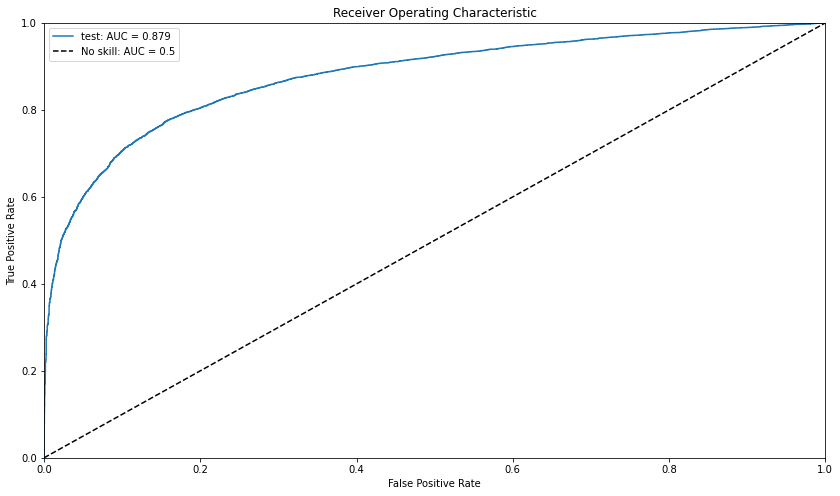

In [116]:
plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

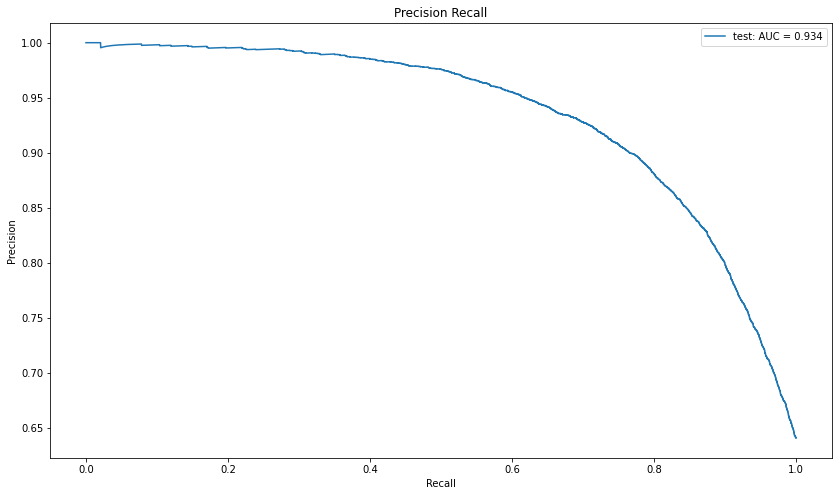

In [117]:
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [9]:
def bbox_dict_to_tensor(pred: dict):
    if "scores" not in pred:
        pred["scores"] = torch.ones_like(pred["labels"])
    return torch.cat((pred["labels"].unsqueeze(1), pred["scores"].unsqueeze(
        1), pred["boxes"]), 1).tolist()

In [10]:
class Observation:
    def __init__(self,bbox):
        self.bboxes= [bbox]
        self.mean = bbox
        self.prediction = bbox[1]
    
    def append(self, bbox):
        self.bboxes.append(bbox)
        self.mean = np.mean(self.bboxes, axis=0).tolist()

    def should_be_grouped(self, bbox, iou_threshold=0.95):
        if int(self.prediction) != int(bbox[1]):
            return False
        if utils.detection_metrics.intersection_over_union(torch.tensor(self.mean[3:]), torch.tensor(bbox[3:])) > iou_threshold:
            return True
        return False

    def __repr__(self):
        return f"{self.mean}, {len(self.bboxes)} bboxes combined"

def combine_boxes(preds):
    observations = []
    for i in preds:
        for bbox in i:
            grouped = False
            for observation in observations:
                if observation.should_be_grouped(bbox, iou_threshold=0.95):
                    observation.append(bbox)
                    grouped = True
                    break
            if not grouped:
                observations.append(Observation(bbox))
    return observations

        


In [48]:
def combine_boxes(preds):
    observations = []
    for i in preds:
        for bbox in i:
            grouped = False
            for observation in observations:
                if observation.should_be_grouped(bbox, iou_threshold=0.95):
                    observation.append(bbox)
                    grouped = True
                    break
            if not grouped:
                observations.append(Observation(bbox))
    return observations

combined = combine_boxes(preds)
        

In [179]:
combined_boxes = [box.mean for box in combined if box.mean[2] > .0 and len(box.bboxes) >= 10]

In [180]:
combined

[[2545.0, 18.0, 0.7907412383291457, 208.78304206000433, 163.27618662516275, 309.7829878065321, 236.16292232937283], 18 bboxes combined,
 [2545.0, 9.0, 0.6469690799713135, 219.9234535217285, 180.7207344055176, 291.6807693481445, 274.20208129882815], 20 bboxes combined,
 [2545.0, 9.0, 0.6824268348076764, 329.272902544807, 169.28854639389937, 403.8654085047105, 258.08900720932905], 17 bboxes combined,
 [2545.0, 9.0, 0.706149246957567, 103.33260515001085, 169.01627434624567, 179.1262681749132, 260.93546888563367], 9 bboxes combined,
 [2545.0, 16.0, 0.5987369894981385, 326.9172709147135, 157.04981384277343, 370.54856363932294, 194.25946146647135], 15 bboxes combined,
 [2545.0, 16.0, 0.600456964969635, 138.21630477905273, 162.72149887084962, 176.06670150756835, 190.09430541992188], 20 bboxes combined,
 [2545.0, 18.0, 0.5768574178218842, 320.61478000217016, 174.70047420925565, 410.3084530300564, 256.33854505750867], 18 bboxes combined,
 [2545.0, 16.0, 0.6306302882730961, 117.02509880065918, 1